In [1]:
import gcsfs
import zarr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio.features import rasterize
from skimage.measure import block_reduce
import time
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from satextractor.utils import tqdm_joblib
import pandas as pd
import geopandas as gpd
from oxeo.water.models.utils import merge_masks, predict_lake
from oxeo.water.metrics import metrics
from skimage.util.shape import view_as_blocks
from oxeo.water.models.segmentation.segmentation_2d import Segmentation2DPredictor

import gcsfs
fs = gcsfs.GCSFileSystem(project='oxeo-main')

In [2]:
import seaborn as sns

In [3]:

shapefile = gpd.read_file("../../ReservoirWatchHack/Data/Contextual_Shapefiles/reservoirs.shp")



In [4]:
shapefile.geometry.to_file('india_reservoirs.geojson', driver='GeoJSON')  

In [5]:
shapefile

,GRAND_ID,RES_NAME,DAM_NAME,ALT_NAME,RIVER,ALT_RIVER,MAIN_BASIN,SUB_BASIN,NEAR_CITY,ALT_CITY,...,MULTI_DAMS,TIMELINE,COMMENTS,URL,QUALITY,EDITOR,LONG_DD,LAT_DD,POLY_SRC,geometry
0,5006,None,Hemavathy,None,Hemavathy,None,Cauvery,None,Hassan,None,...,None,None,None,None,2: Good,McGill-BL,76.054284,12.824532,SWBD,"POLYGON ((76.00163 12.89112, 76.00228 12.89084..."
1,5009,Khrishnaraja,Krisharaja Sagar,None,Cauvery,None,Cauvery,None,Mysore,None,...,None,None,None,None,3: Fair,McGill-BL,76.571091,12.422930,SWBD,"POLYGON ((76.45833 12.55605, 76.45477 12.55256..."
2,5013,None,Kabini,None,Kabini,None,Cauvery,None,H.D. Kote,None,...,None,None,None,None,3: Fair,McGill-BL,76.350878,11.969304,SWBD,"POLYGON ((76.34139 12.00334, 76.34096 12.00070..."
3,0,Harangi,Harangi,None,None,None,Cauvery,None,None,None,...,None,None,None,None,None,None,0.000000,0.000000,None,"MULTIPOLYGON (((75.84781 12.49959, 75.84780 12..."


In [6]:
patches_paths = fs.ls('oxeo-water/eo')
patches_paths



['oxeo-water/eo/',
 'oxeo-water/eo/bigbear',
 'oxeo-water/eo/cornu',
 'oxeo-water/eo/harangi',
 'oxeo-water/eo/hemavathy',
 'oxeo-water/eo/hoover',
 'oxeo-water/eo/kabini',
 'oxeo-water/eo/krishnaraja_sagar']

In [7]:
predictor = Segmentation2DPredictor(ckpt_path='../checkpoints/epoch=52_val_loss=0.ckpt')

In [13]:
dam = "kabini"

patches_paths = fs.ls('oxeo-water/eo/kabini')
print(patches_paths)

preds_09, dates = predict_lake(predictor, patches_paths, 1000,datetime(2011,2,9),datetime(2021,10,25), 
                            threshold=0.99, date_batch=150)


2021-11-17 03:46:59.234 | INFO     | oxeo.water.models.utils:predict_lake:126 - Getting full lake data for between 2011-02-09 00:00:00 and 2021-10-25 00:00:00


['oxeo-water/eo/kabini/32643_0_0', 'oxeo-water/eo/kabini/32643_0_1', 'oxeo-water/eo/kabini/32643_1_0', 'oxeo-water/eo/kabini/32643_1_1']


2021-11-17 03:47:09.478 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:136 - Moving model to GPU.
2021-11-17 03:47:28.376 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:153 - Moving model to CPU.
2021-11-17 03:47:39.153 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:136 - Moving model to GPU.
2021-11-17 03:47:59.260 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:153 - Moving model to CPU.
2021-11-17 03:48:10.704 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:136 - Moving model to GPU.
2021-11-17 03:48:30.728 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:153 - Moving model to CPU.
2021-11-17 03:48:41.500 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:136 - Moving model to GPU.
2021-11-17 03:49:01.550 | INFO     | oxeo.water.models.segmentation.segmentation_2d:predict:153 - Moving model to CPU.
2021-11-17 03:49:21.192 | INFO     | oxeo.water.

In [ ]:
preds.reshape(-1, 2000, 2000).shape

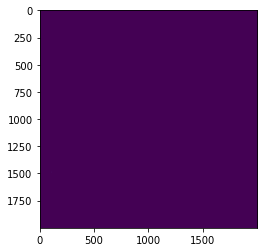

In [11]:
plt.imshow(preds_final[290])

In [14]:
dam = "kabini"
dates_str = [d.strftime("%Y-%m-%d") for d in dates]
dam_df = pd.read_csv(f"../../ReservoirWatchHack/Data/CWC_WaterLevels/{dam}.csv")
dam_df = dam_df[dam_df.FLOW_DATE.isin(dates_str)].sort_values(by="FLOW_DATE")
dates_mask = pd.Series(dates_str).isin(dam_df.FLOW_DATE).values

preds_final = preds_09[np.where(dates_mask)[0], ...]

In [ ]:
preds_final>0.5

In [ ]:
plt.imshow(preds_final[25]>0.5)

In [ ]:
dam = "Harangi"

patches_paths = fs.ls('oxeo-water/eo/harangi')
print(patches_paths)

print("Merging masks")
full_mask,dates= merge_masks(patches_paths, 1000,datetime(2011,2,9),datetime(2021,10,25))
full_mask = full_mask.astype(np.uint8)
print("Masks merged")
dates_str = [d.strftime("%Y-%m-%d") for d in dates]
dam_df = pd.read_csv(f"../../ReservoirWatchHack/Data/CWC_WaterLevels/{dam}.csv")
dam_df = dam_df[dam_df.FLOW_DATE.isin(dates_str)].sort_values(by="FLOW_DATE")
dates_mask = pd.Series(dates_str).isin(dam_df.FLOW_DATE).values

full_mask = full_mask[np.where(dates_mask)[0], ...]

Getting areas
Plotting


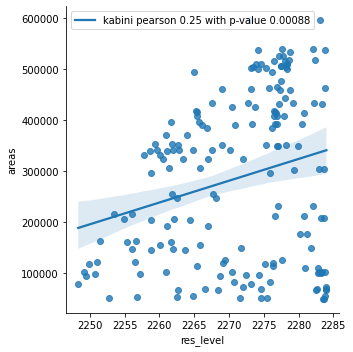

In [19]:
print("Getting areas")
areas = metrics.segmentation_area(preds_final)
data = pd.DataFrame({"res_level": dam_df.RES_LEVEL_FT.astype(float), "areas": areas})
data = data[data.areas > 50000]
from scipy import stats
val, p = stats.pearsonr(data['res_level'], data['areas'])
print("Plotting")
sns.lmplot(x="res_level", y="areas", data=data)
plt.legend(labels=[f'{dam} pearson {val:.2f} with p-value {p:.5f}'])
plt.show()

In [ ]:
# Unet Prediction

import glob
import os
from argparse import ArgumentParser

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from oxeo.water.callbacks.wandb_callbacks import LogImagePredictions
from oxeo.water.datamodules import SegmentationDataModule
from oxeo.water.models.segmentation import Segmentation2D


model = Segmentation2D.load_from_checkpoint("../checkpoints/epoch=52_val_loss=0.ckpt", input_channels=13,
                                           num_classes=1)


model.eval().cuda()
transform = None

train_dams = ["harangi", "hemavathy", "krishnaraja_sagar"]
val_dams = ["kabini"]
train_paths = []
for d in train_dams:
    train_paths.extend(
        glob.glob(f"/home/fran/repos/oxeo-water/data/oxeo-water/eo/{d}/*/*")
    )
val_paths = glob.glob("/home/fran/repos/oxeo-water/data/oxeo-water/eo/kabini/*/*")
# Instantiate it (we are using here the Embeddings data module, without labels)
sdm = SegmentationDataModule(
    transforms=transform,
    batch_size=128,
    num_workers=8,
    train_paths=train_paths,
    val_paths=val_paths,
)
sdm.setup()


In [ ]:
val_dl = sdm.val_dataloader()

In [ ]:
max_date = max([eval(v.split('_')[-3]) for v in val_paths])

In [ ]:
from itertools import compress

In [ ]:
filtered_preds = list(compress(preds, date_indices))

In [ ]:
(torch.sigmoid(torch.as_tensor(filtered_preds)) >= 0.5).squeeze().numpy().reshape((1,100, -1)).shape

In [ ]:
torch.as_tensor(np.array(preds)[date_indices]).squeeze().shape

In [ ]:
np.array(labels)

In [ ]:
areas = []
for d in range(298):
    date_indices = [i for i,v_path in enumerate(val_paths) if v_path.split('_')[-3] == str(d)]
    filtered_preds = list(compress(preds, date_indices))
    sigmoid_preds = torch.sigmoid(torch.as_tensor(filtered_preds))
    pred_masks = (sigmoid_preds >= 0.9).squeeze().numpy().reshape((1,-1))
    print(np.array(list(compress(labels, date_indices))).shape)
    ori_masks = torch.as_tensor(list(compress(labels, date_indices))).squeeze().numpy().reshape((1,-1))
    #print(sigmoid_preds.max())
    plt.imshow(sigmoid_preds[1,0])
    plt.show()
    print(metrics.segmentation_area(pred_masks), metrics.segmentation_area(ori_masks))

In [ ]:
val_paths

In [ ]:
preds = []
for b in tqdm(iter(val_dl)):
    preds.extend(model(b['data'].float().cuda()).data.cpu().numpy())

In [ ]:
labels = []
for b in tqdm(iter(val_dl)):
    labels.extend(b['label'].numpy())

In [ ]:
import torch

In [ ]:
torch.sigmoid(torch.as_tensor(preds[0].squeeze()))

In [ ]:
plt.imshow(sdm.val_dataset[207]['data'][2])

In [ ]:
plt.imshow(torch.as_tensor(labels[207].squeeze()))

In [ ]:
plt.imshow(torch.sigmoid(torch.as_tensor(preds[207].squeeze()))>0.59)

In [ ]:
unet_pred = model.predict_dataloader()

In [ ]:



# Train ##################################################




trainer = pl.Trainer.from_argparse_args(
    args,
    logger=wandb_logger,
    callbacks=[
        checkpoint_callback,
        LogImagePredictions(),
        # LearningRateMonitor(logging_interval="step"),
    ],
    precision=args.precision,
    limit_train_batches=args.limit_train_batches,
    limit_val_batches=args.limit_val_batches,
    max_epochs=args.max_epochs,
)

trainer.fit(model, datamodule=sdm)
